In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv(r"C:\Users\asmit\Downloads\all_three.csv")

# Drop unnecessary column
df = df.drop(columns=["Unnamed: 0"])

# Split features and target
X = df.drop(columns=["label"])
y = df["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (important for LR and LSTM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
estimators = [
    ('lr', LogisticRegression(max_iter=1000, C=0.5)),                     # regularization
    ('dt', DecisionTreeClassifier(max_depth=5, min_samples_split=10)),    # pruning
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10))        # limit RF complexity
]
# Stacking ensemble

stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(C=0.3))
stack_model.fit(X_train_scaled, y_train)

# Accuracy on train and test

train_acc = accuracy_score(y_train, stack_model.predict(X_train_scaled))
test_acc = accuracy_score(y_test, stack_model.predict(X_test_scaled))
# Cross-validation accuracy
cv_scores = cross_val_score(stack_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
# Print results
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Cross-Val Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Train Accuracy: 0.9892
Test Accuracy:  0.9880
Cross-Val Accuracy: 0.9887 ± 0.0003


In [12]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_acc:.4f}")


c:\Users\asmit\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [12:49:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9823


In [13]:
from sklearn.metrics import accuracy_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Prepare data for LSTM: reshape and one-hot encode
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Get number of output classes
num_classes = y_train_cat.shape[1]

# Function to create LSTM model
def build_lstm_model():
    model = Sequential([
        LSTM(64, input_shape=(1, X_train_scaled.shape[1]), return_sequences=False),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')  # <-- dynamically set output layer
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train ensemble
ensemble_preds = []
for _ in range(3):  
    model = build_lstm_model()
    model.fit(X_train_lstm, y_train_cat, epochs=3, batch_size=128, verbose=0)
    preds = model.predict(X_test_lstm)
    ensemble_preds.append(preds)

# Average predictions and evaluate
avg_preds = np.mean(ensemble_preds, axis=0)
y_pred_lstm = np.argmax(avg_preds, axis=1)
lstm_acc = accuracy_score(y_test, y_pred_lstm)
print(f"LSTM Ensemble Accuracy: {lstm_acc:.4f}")


2673/2673 [==============================] - 2s 711us/step
LSTM Ensemble Accuracy: 0.9845


In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

# RMS for LSTM
lstm_rms = np.sqrt(mean_squared_error(y_test_cat, avg_preds))
print(f"LSTM RMS: {lstm_rms:.4f}")

# RMS for Stacking (you must have stack_model.predict_proba())
stack_probs = stack_model.predict_proba(X_test_scaled)
stack_rms = np.sqrt(mean_squared_error(y_test_cat, stack_probs))
print(f"Stacking RMS: {stack_rms:.4f}")

# RMS for XGBoost
xgb_probs = xgb_model.predict_proba(X_test)
xgb_rms = np.sqrt(mean_squared_error(y_test_cat, xgb_probs))
print(f"XGBoost RMS: {xgb_rms:.4f}")


LSTM RMS: 0.0721
Stacking RMS: 0.0559
XGBoost RMS: 0.0628


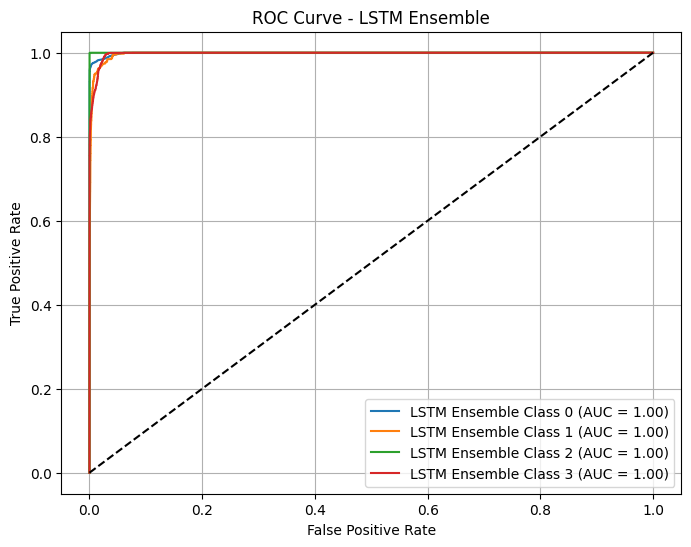

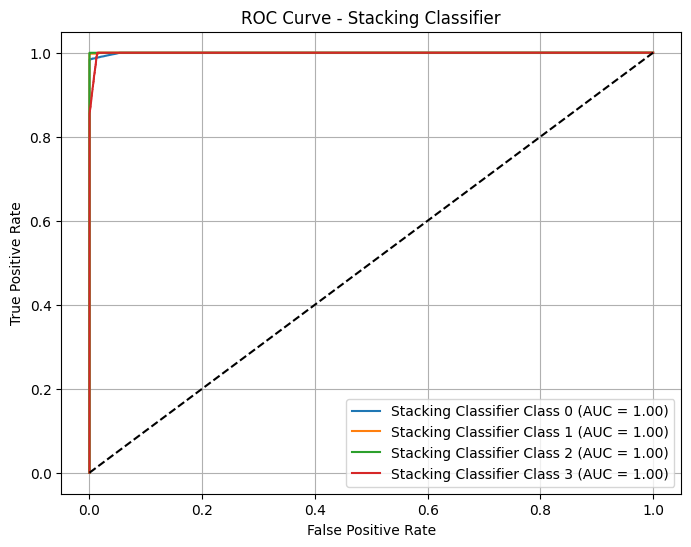

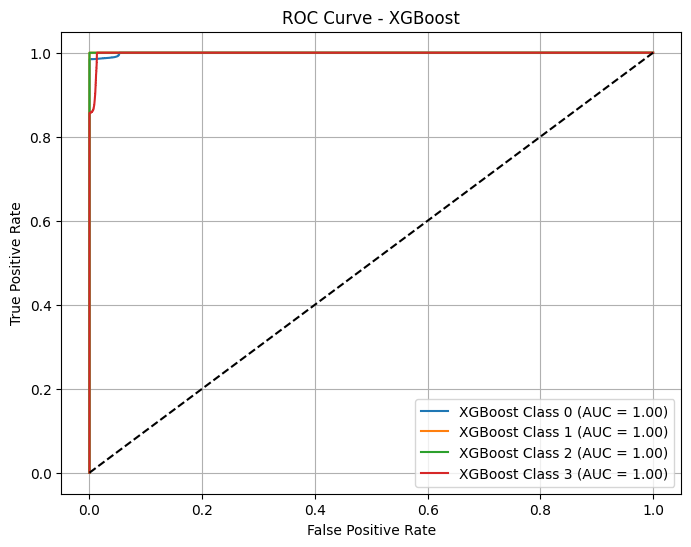

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize y_test for ROC (one-hot)
y_test_bin = label_binarize(y_test, classes=np.arange(y_test_cat.shape[1]))
n_classes = y_test_cat.shape[1]

def plot_roc_curves(y_true, y_scores, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'{model_name} Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Plot for all models
plot_roc_curves(y_test_bin, avg_preds, "LSTM Ensemble")
plot_roc_curves(y_test_bin, stack_probs, "Stacking Classifier")
plot_roc_curves(y_test_bin, xgb_probs, "XGBoost")


In [16]:
from sklearn.metrics import accuracy_score

train_accuracies = []
test_accuracies = []

for _ in range(3):  
    model = build_lstm_model()
    history = model.fit(X_train_lstm, y_train_cat, epochs=3, batch_size=128, verbose=0)
    
    train_preds = model.predict(X_train_lstm)
    test_preds = model.predict(X_test_lstm)

    train_acc = accuracy_score(np.argmax(y_train_cat, axis=1), np.argmax(train_preds, axis=1))
    test_acc = accuracy_score(np.argmax(y_test_cat, axis=1), np.argmax(test_preds, axis=1))

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

print(f"LSTM Train Accuracy: {np.mean(train_accuracies):.4f}")
print(f"LSTM Test Accuracy:  {np.mean(test_accuracies):.4f}")


2673/2673 [==============================] - 2s 730us/step
LSTM Train Accuracy: 0.9849
LSTM Test Accuracy:  0.9841


In [17]:
# Accuracy on train and test
train_acc = accuracy_score(y_train, stack_model.predict(X_train_scaled))
test_acc = accuracy_score(y_test, stack_model.predict(X_test_scaled))

print(f"Stacking Train Accuracy: {train_acc:.4f}")
print(f"Stacking Test Accuracy:  {test_acc:.4f}")

if train_acc - test_acc > 0.1:
    print("🔴 Stacking model may be overfitting.")
elif train_acc < 0.7 and test_acc < 0.7:
    print("🟠 Stacking model may be underfitting.")
else:
    print("🟢 Stacking model seems reasonably fit.")


Stacking Train Accuracy: 0.9892
Stacking Test Accuracy:  0.9880
🟢 Stacking model seems reasonably fit.


In [18]:
# XGBoost train and test accuracy
xgb_train_preds = xgb_model.predict(X_train)
xgb_train_acc = accuracy_score(y_train, xgb_train_preds)

print(f"XGBoost Train Accuracy: {xgb_train_acc:.4f}")
print(f"XGBoost Test Accuracy:  {xgb_acc:.4f}")  # already calculated

if xgb_train_acc - xgb_acc > 0.1:
    print("🔴 XGBoost model may be overfitting.")
elif xgb_train_acc < 0.7 and xgb_acc < 0.7:
    print("🟠 XGBoost model may be underfitting.")
else:
    print("🟢 XGBoost model seems reasonably fit.")


XGBoost Train Accuracy: 0.9909
XGBoost Test Accuracy:  0.9823
🟢 XGBoost model seems reasonably fit.


In [19]:
# LSTM train and test accuracy (from ensemble)
lstm_train_acc = np.mean(train_accuracies)  # From earlier ensemble training loop
lstm_test_acc = lstm_acc  # Already calculated for LSTM

print(f"LSTM Train Accuracy: {lstm_train_acc:.4f}")
print(f"LSTM Test Accuracy:  {lstm_test_acc:.4f}")

if lstm_train_acc - lstm_test_acc > 0.1:
    print("🔴 LSTM model may be overfitting.")
elif lstm_train_acc < 0.7 and lstm_test_acc < 0.7:
    print("🟠 LSTM model may be underfitting.")
else:
    print("🟢 LSTM model seems reasonably fit.")


LSTM Train Accuracy: 0.9849
LSTM Test Accuracy:  0.9845
🟢 LSTM model seems reasonably fit.


In [20]:
feature_names = X.columns  # This will give you feature names


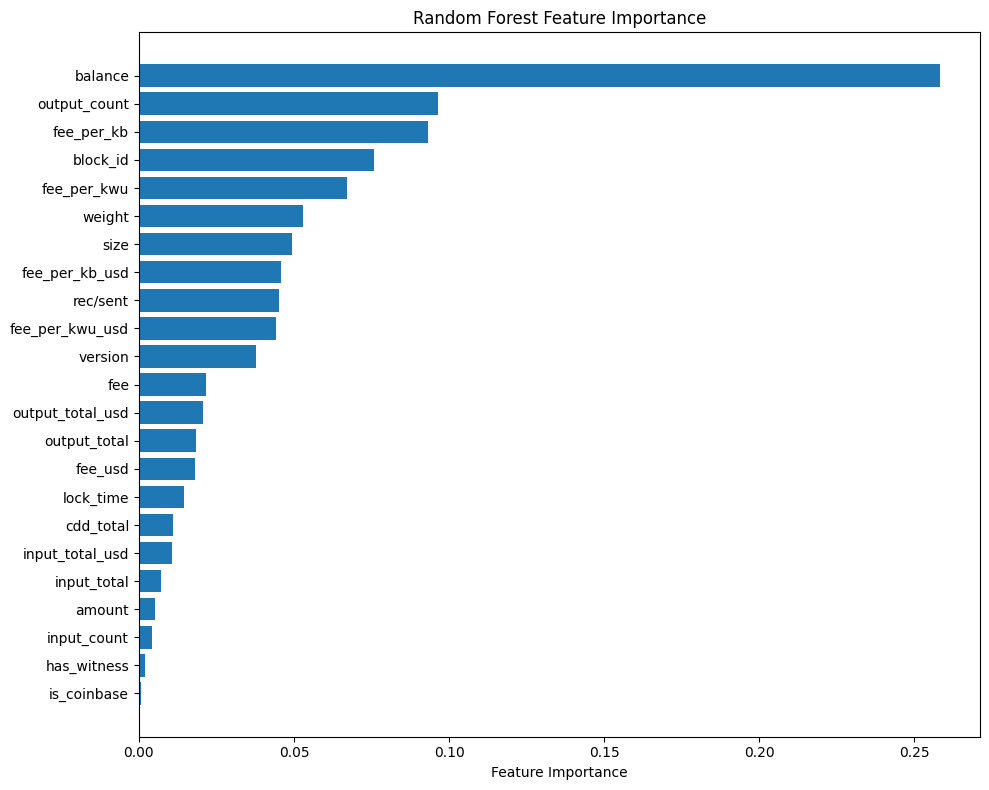

In [21]:
import matplotlib.pyplot as plt
import numpy as np

rf_importance = stack_model.named_estimators_['rf'].feature_importances_
feature_names = X.columns  # replace X with your DataFrame

# Sort by importance
sorted_idx = np.argsort(rf_importance)

plt.figure(figsize=(10, 8))
plt.barh(range(len(rf_importance)), rf_importance[sorted_idx])
plt.yticks(range(len(rf_importance)), feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


In [22]:
feature_names = X.columns  # assuming X is a pandas DataFrame


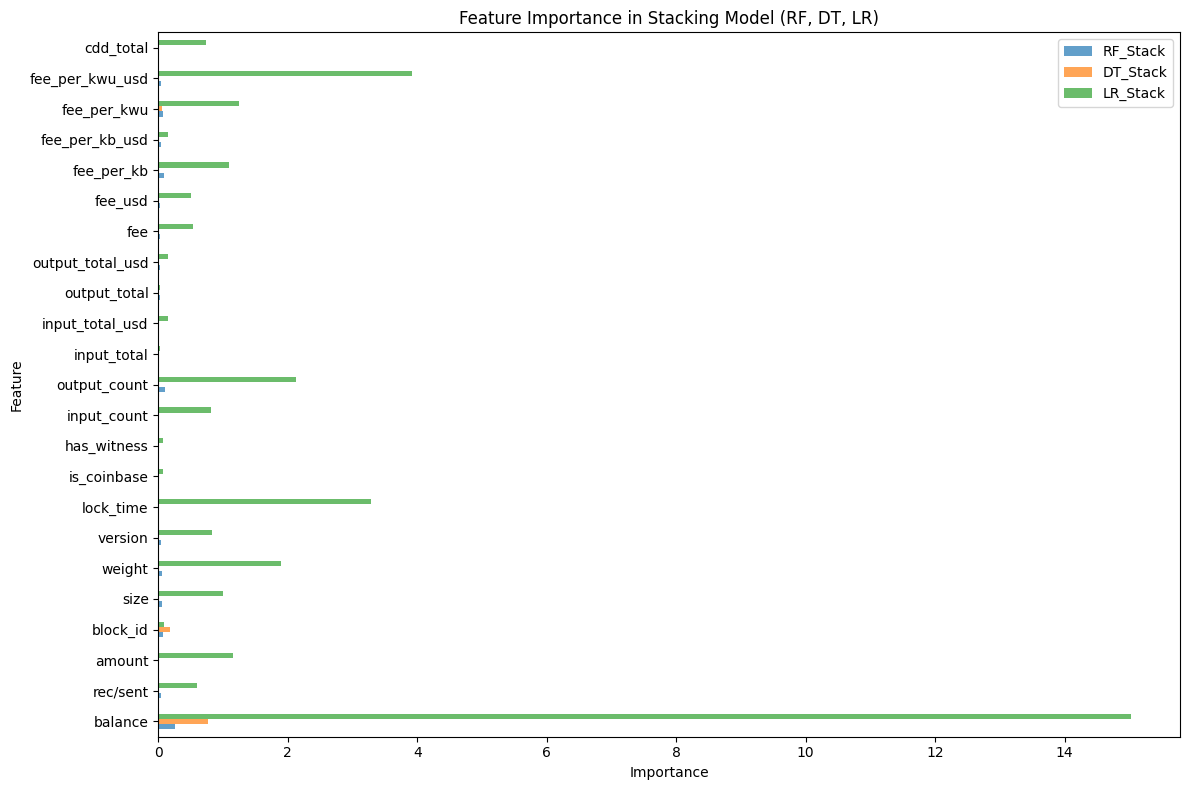

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Random Forest
rf_importance = stack_model.named_estimators_['rf'].feature_importances_
dt_importance = stack_model.named_estimators_['dt'].feature_importances_
lr_coef = np.abs(stack_model.named_estimators_['lr'].coef_[0])

df_stack = pd.DataFrame({
    'Feature': feature_names,
    'RF_Stack': rf_importance,
    'DT_Stack': dt_importance,
    'LR_Stack': lr_coef
})
df_stack.set_index('Feature').plot(kind='barh', figsize=(12, 8), alpha=0.7)
plt.title("Feature Importance in Stacking Model (RF, DT, LR)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


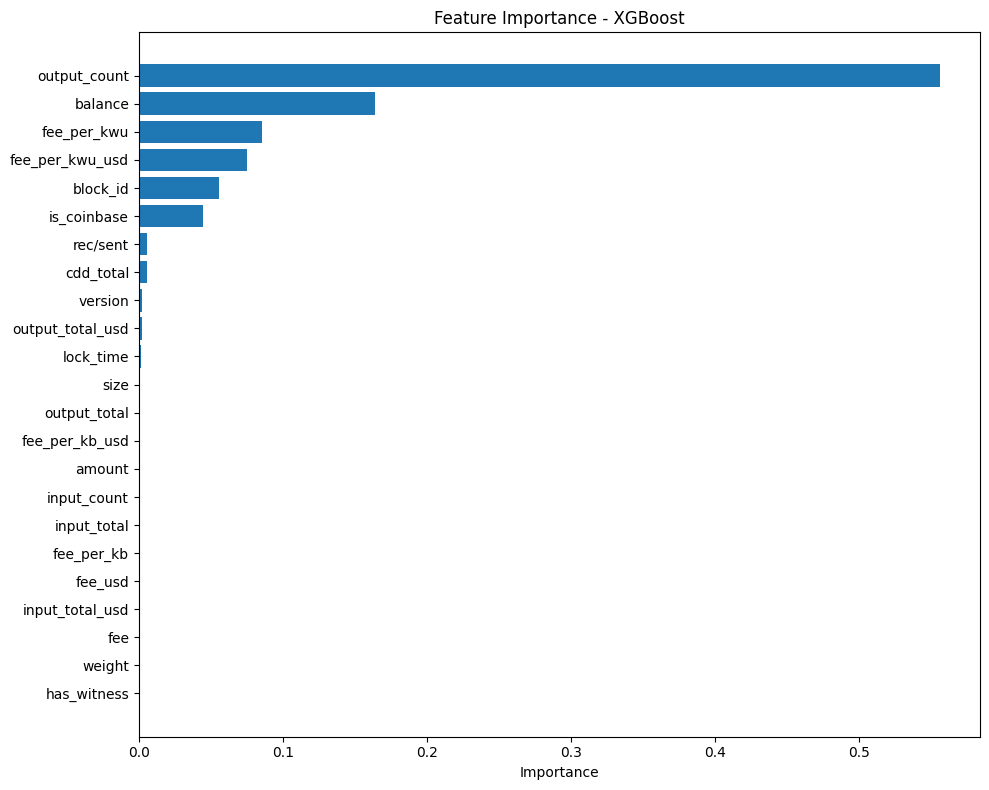

In [24]:
xgb_importance = xgb_model.feature_importances_

df_xgb = pd.DataFrame({
    'Feature': feature_names,
    'XGBoost': xgb_importance
}).sort_values(by='XGBoost', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(df_xgb['Feature'], df_xgb['XGBoost'])
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


C:\Users\asmit\AppData\Local\Temp\ipykernel_24356\2004573751.py:36: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\asmit\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


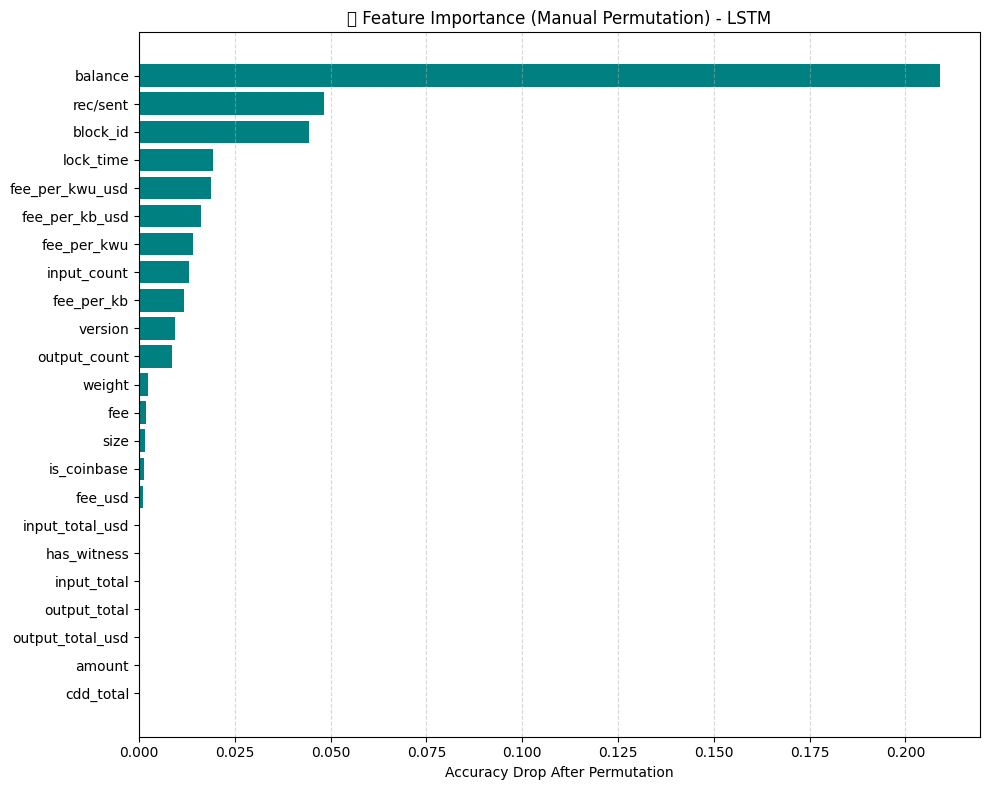

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from copy import deepcopy

# Your LSTM model must already be trained as: model
# Ensure X_test_scaled is a numpy array
X_test_copy = deepcopy(X_test_scaled)
baseline_preds = np.argmax(model.predict(X_test_copy.reshape((-1, 1, X_test_copy.shape[1])), verbose=0), axis=1)
baseline_score = accuracy_score(y_test, baseline_preds)

# Calculate permutation importance manually
feature_names = X.columns.tolist()
importances = []

for i in range(X_test_copy.shape[1]):
    X_permuted = deepcopy(X_test_copy)
    np.random.shuffle(X_permuted[:, i])  # Shuffle only column i
    permuted_preds = np.argmax(model.predict(X_permuted.reshape((-1, 1, X_test_copy.shape[1])), verbose=0), axis=1)
    permuted_score = accuracy_score(y_test, permuted_preds)
    importance = baseline_score - permuted_score
    importances.append(importance)

# Plot results
df_lstm = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(df_lstm['Feature'], df_lstm['Importance'], color='teal')
plt.title("🔍 Feature Importance (Manual Permutation) - LSTM")
plt.xlabel("Accuracy Drop After Permutation")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [31]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score
import numpy as np

# Reshape the input for LSTM (RNN model)
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Predictions for LSTM
y_pred_lstm = np.argmax(model.predict(X_test_lstm), axis=1)

# Accuracy
lstm_acc = accuracy_score(y_test, y_pred_lstm)
print(f"LSTM Accuracy: {lstm_acc:.4f}")

# Precision
lstm_precision = precision_score(y_test, y_pred_lstm, average='macro')
print(f"LSTM Precision: {lstm_precision:.4f}")

# F1-Score
lstm_f1 = f1_score(y_test, y_pred_lstm, average='macro')
print(f"LSTM F1-Score: {lstm_f1:.4f}")

# AUC (Area Under Curve)
lstm_auc = roc_auc_score(y_test, model.predict(X_test_lstm), multi_class='ovr', average='macro')  # For multi-class classification
print(f"LSTM AUC: {lstm_auc:.4f}")


2673/2673 [==============================] - 2s 873us/step
LSTM Accuracy: 0.9841
LSTM Precision: 0.9314
LSTM F1-Score: 0.8933
2673/2673 [==============================] - 2s 864us/step
LSTM AUC: 0.9986


In [32]:
# Predictions for Stacking
y_pred_stack = stack_model.predict(X_test_scaled)

# Accuracy
stack_acc = accuracy_score(y_test, y_pred_stack)
print(f"Stacking Accuracy: {stack_acc:.4f}")

# Precision
stack_precision = precision_score(y_test, y_pred_stack, average='macro')
print(f"Stacking Precision: {stack_precision:.4f}")

# F1-Score
stack_f1 = f1_score(y_test, y_pred_stack, average='macro')
print(f"Stacking F1-Score: {stack_f1:.4f}")

# AUC
stack_auc = roc_auc_score(y_test, stack_model.predict_proba(X_test_scaled), multi_class='ovr', average='macro')
print(f"Stacking AUC: {stack_auc:.4f}")


Stacking Accuracy: 0.9880
Stacking Precision: 0.9829
Stacking F1-Score: 0.9770
Stacking AUC: 0.9996


In [33]:
# Predictions for XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Accuracy
xgb_acc = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_acc:.4f}")

# Precision
xgb_precision = precision_score(y_test, y_pred_xgb, average='macro')
print(f"XGBoost Precision: {xgb_precision:.4f}")

# F1-Score
xgb_f1 = f1_score(y_test, y_pred_xgb, average='macro')
print(f"XGBoost F1-Score: {xgb_f1:.4f}")

# AUC
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test), multi_class='ovr', average='macro')
print(f"XGBoost AUC: {xgb_auc:.4f}")


XGBoost Accuracy: 0.9823
XGBoost Precision: 0.9715
XGBoost F1-Score: 0.9687
XGBoost AUC: 0.9994


In [35]:
import numpy as np
from sklearn.metrics import mean_squared_error

# LSTM RMS
lstm_rms = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
print(f"LSTM RMS: {lstm_rms:.4f}")

# XGBoost RMS
xgb_rms = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost RMS: {xgb_rms:.4f}")

# Stacking RMS
stacking_rms = np.sqrt(mean_squared_error(y_test, stack_model.predict(X_test_scaled)))
print(f"Stacking RMS: {stacking_rms:.4f}")


LSTM RMS: 0.3538
XGBoost RMS: 0.3993
Stacking RMS: 0.3273
